# 3.1 Modelo ML Supervisado de Regresión "Views"
3.1.1 Preparación dataset

3.1.2 Modelo logístico

3.1.3 Árbol de decisión

3.1.4 Random forrest

3.1.5 XGBOOST

3.1.5.1 Fine tunning y SHAP

3.1.6 Red Neuronal

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns        
import matplotlib.pyplot as plt 
import glob
import os
import time    
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler, Normalizer
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from scipy import sparse
from xgboost.callback import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_predict
import shap
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


/opt/anaconda3/envs/yt-ml-spvd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval_regression(model, X_train, X_test, y_train, y_test, print_digits=3, include_mape=True):
    """
    Evalúa un modelo de regresión ya entrenado sobre train y test.
    Retorna un diccionario con métricas y las imprime formateadas.

    Parámetros:
    - model: estimador sklearn (ya .fit)
    - X_train, X_test, y_train, y_test: conjuntos de datos
    - print_digits: nº de decimales al imprimir
    - include_mape: si True, calcula MAPE (ignora y==0 para evitar división por cero)
    """
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # --- MÉTRICAS ---
    # Train
    mae_tr  = mean_absolute_error(y_train, y_pred_train)
    mse_tr  = mean_squared_error(y_train, y_pred_train)
    rmse_tr = np.sqrt(mse_tr)
    r2_tr   = r2_score(y_train, y_pred_train)

    # Test
    mae_te  = mean_absolute_error(y_test, y_pred_test)
    mse_te  = mean_squared_error(y_test, y_pred_test)
    rmse_te = np.sqrt(mse_te)
    r2_te   = r2_score(y_test, y_pred_test)

    # MAPE (opcional, excluye y==0)
    mape_tr = mape_te = None
    if include_mape:
        mask_tr = (np.array(y_train) != 0)
        mask_te = (np.array(y_test)  != 0)
        if mask_tr.any():
            mape_tr = np.mean(np.abs((y_train[mask_tr] - y_pred_train[mask_tr]) / y_train[mask_tr])) * 100
        if mask_te.any():
            mape_te = np.mean(np.abs((y_test[mask_te] - y_pred_test[mask_te]) / y_test[mask_te])) * 100

    # Impresión bonita
    def r(x): 
        return None if x is None else round(x, print_digits)

    print(f"— TRAIN —  MAE: {r(mae_tr)} | MSE: {r(mse_tr)} | RMSE: {r(rmse_tr)} | R²: {r(r2_tr)}"
          + (f" | MAPE: {r(mape_tr)}%" if include_mape and mape_tr is not None else ""))
    print(f"— TEST  —  MAE: {r(mae_te)} | MSE: {r(mse_te)} | RMSE: {r(rmse_te)} | R²: {r(r2_te)}"
          + (f" | MAPE: {r(mape_te)}%" if include_mape and mape_te is not None else ""))

    return {
        "train": {"MAE": mae_tr, "MSE": mse_tr, "RMSE": rmse_tr, "R2": r2_tr, "MAPE": mape_tr},
        "test":  {"MAE": mae_te, "MSE": mse_te, "RMSE": rmse_te, "R2": r2_te, "MAPE": mape_te},
        "y_pred_train": y_pred_train,
        "y_pred_test": y_pred_test
    }

### 3.1.1. PREPARACIÓN DATASET

In [ ]:
df_1=pd.read_parquet("df_TFMYouTube_embeddings_UMAP5_CLUSTERS_UMAP2.parquet")

In [4]:
cols= ['category_id','duration_minutes', "comments","views","has_caption","licensed_content","definition","tags_count","likes",
    "channel_video_count","channel_age_days","frecuencia_videos","channel_views","subscriber_count",'embedding_joint',"channel_id"]
df_1=df_1[cols]

In [5]:
df_1["views_per_subscriber"] = df_1["channel_views"] / df_1["subscriber_count"].replace(0, np.nan)

num_cols = [
    "duration_minutes","tags_count","views_per_subscriber","comments","likes",
    "has_caption","licensed_content","definition",
    "channel_video_count","channel_age_days","frecuencia_videos"
    # si vas a usar estas derivadas en num_cols, inclúyelas aquí:
    # "views_per_day","frecuencia_videos","views_rate_video",
    # "likes_per_view","comments_per_view","efficiency","engagement_subscribers"
]

cols_used = list(set(num_cols + ["category_id", "embedding_joint"]))

In [6]:

y = np.log1p(df_1["views"])# (df_1["views"]) # en escala lineal / provar: 
X = df_1[cols_used].copy()
channels = df_1["channel_id"].unique()
train_ch, test_ch = train_test_split(channels, test_size=0.2, random_state=42)
mask_tr = df_1["channel_id"].isin(train_ch)
mask_te = df_1["channel_id"].isin(test_ch)

X_train, y_train = X[mask_tr], y[mask_tr]
X_test,  y_test  = X[mask_te], y[mask_te]


In [7]:
# Asegurar que las columnas de embeddings existen
assert 'embedding_joint' in X.columns, \
       "Faltan columnas de embeddings en X."

num_cols = num_cols  # tus columnas numéricas
cat_cols = ['category_id']  # o las que correspondan

# --- pipes por bloque ---
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    #("robust", RobustScaler()),               # mitiga outliers
    ("pt", PowerTransformer(method="yeo-johnson", standardize=True)),  # transforma a distribución normal
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True, min_frequency=10)),
])

# Helper para embeddings: apilar la serie de arrays (n,1) -> (n, d)
def stack_array_col(X):
    # X llega como DataFrame (n,1) con cada celda = np.ndarray
    return np.vstack(X.iloc[:, 0].to_numpy()).astype("float32")

# Pipeline para embedding_joint
emb_joint_pipe = Pipeline([
    ("stack", FunctionTransformer(stack_array_col, validate=False)),
    ("pca", PCA(n_components=50, random_state=42)),  # ajusta n_components según dataset
])

# --- ColumnTransformer completo ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
        ("emb_joint", emb_joint_pipe, ["embedding_joint"]),
    ],
    remainder="drop",
    sparse_threshold=0.3,  # mantiene salida esparsa si hay al menos un bloque esparso
)


### 3.1.2. REGRESION LOGISTICA

In [8]:

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),   # tu ColumnTransformer ya definido
    ('model', LinearRegression())
])

# 2) CV por canal dentro de TRAIN
groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="r2",
    n_jobs=-1
)
print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

# 3) Entrena en TODO el train y evalúa en test hold-out
pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)


print("Hold-out R²:", r2_score(y_test, y_pred_test))
print("Hold-out MAE:", mean_absolute_error(y_test, y_pred_test))
print("Hold-out RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
eval_regression(pipeline_power,X_train, X_test, y_train, y_test)

CV R² (mean±std): 0.735 ± 0.009
Hold-out R²: 0.7223756765563012
Hold-out MAE: 0.7002166075714775
Hold-out RMSE: 0.9715475401212909
— TRAIN —  MAE: 0.685 | MSE: 0.89 | RMSE: 0.943 | R²: 0.745 | MAPE: 9.09%
— TEST  —  MAE: 0.7 | MSE: 0.944 | RMSE: 0.972 | R²: 0.722 | MAPE: 8.9%


{'train': {'MAE': 0.6848495937687383,
  'MSE': 0.8900369765111207,
  'RMSE': 0.9434177105138108,
  'R2': 0.7451652000606902,
  'MAPE': 9.089893217306571},
 'test': {'MAE': 0.7002166075714775,
  'MSE': 0.9439046227157312,
  'RMSE': 0.9715475401212909,
  'R2': 0.7223756765563012,
  'MAPE': 8.90029772121952},
 'y_pred_train': array([ 6.75079346, 12.71893311,  8.49841309, ...,  8.55438232,
         8.69561768,  9.80731201]),
 'y_pred_test': array([ 8.74230957,  9.39147949,  8.33294678, ...,  7.74591064,
        11.39746094,  8.77716064])}

### 3.1.3. ARBOL DECISION

In [9]:
tree_clf = DecisionTreeRegressor(
   # criterion="log_loss",        # o "entropy"/"log_loss"
    max_depth=6,             # prueba 6–12 según tu data
    min_samples_leaf=18,     # sube/baja para controlar sobreajuste
   # class_weight="balanced", # importante con tu desbalance
    random_state=42
)

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', tree_clf)
])
groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="r2",
    n_jobs=-1
)
print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

# 3) Entrena en TODO el train y evalúa en test hold-out
pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)


print("Hold-out R²:", r2_score(y_test, y_pred_test))
print("Hold-out MAE:", mean_absolute_error(y_test, y_pred_test))
print("Hold-out RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
eval_regression(pipeline_power,X_train, X_test, y_train, y_test)


CV R² (mean±std): 0.780 ± 0.020
Hold-out R²: 0.7761597457570402
Hold-out MAE: 0.6408107517456906
Hold-out RMSE: 0.8723773779065563
— TRAIN —  MAE: 0.605 | MSE: 0.674 | RMSE: 0.821 | R²: 0.807 | MAPE: 8.046%
— TEST  —  MAE: 0.641 | MSE: 0.761 | RMSE: 0.872 | R²: 0.776 | MAPE: 8.297%


{'train': {'MAE': 0.6045186913923665,
  'MSE': 0.6739442382316481,
  'RMSE': 0.8209410686715874,
  'R2': 0.8070367303241286,
  'MAPE': 8.045571395715859},
 'test': {'MAE': 0.6408107517456906,
  'MSE': 0.7610422894831187,
  'RMSE': 0.8723773779065563,
  'R2': 0.7761597457570402,
  'MAPE': 8.296953630921806},
 'y_pred_train': array([ 6.4139113 , 13.40029315,  7.91130053, ...,  8.468677  ,
         8.468677  , 10.08733907]),
 'y_pred_test': array([ 8.468677  ,  9.20071392,  7.91234844, ...,  8.468677  ,
        11.83138216, 10.08733907])}

### 3.1.4 RANDOM FORREST

In [10]:

rf = RandomForestRegressor(random_state=42, n_estimators=50,n_jobs=-1) 

pipeline_power = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', rf)
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
assert len(groups) == len(X_train)
gkf = GroupKFold(n_splits=5)

cv_scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,
    groups=groups,
    scoring="r2",
    n_jobs=-1
)
print(f"CV R² (mean±std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")  

# 3) Entrena en TODO el train y evalúa en test hold-out
pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)


print("Hold-out R²:", r2_score(y_test, y_pred_test))
print("Hold-out MAE:", mean_absolute_error(y_test, y_pred_test))
print("Hold-out RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
eval_regression(pipeline_power,X_train, X_test, y_train, y_test)


CV R² (mean±std): 0.836 ± 0.017
Hold-out R²: 0.8385662765077166
Hold-out MAE: 0.5369081537583652
Hold-out RMSE: 0.7408536619443195
— TRAIN —  MAE: 0.206 | MSE: 0.083 | RMSE: 0.289 | R²: 0.976 | MAPE: 2.715%
— TEST  —  MAE: 0.537 | MSE: 0.549 | RMSE: 0.741 | R²: 0.839 | MAPE: 6.96%


{'train': {'MAE': 0.20611155174565793,
  'MSE': 0.08341332999410495,
  'RMSE': 0.2888136596390568,
  'R2': 0.9761171503855449,
  'MAPE': 2.7145076388445153},
 'test': {'MAE': 0.5369081537583652,
  'MSE': 0.5488641484163079,
  'RMSE': 0.7408536619443195,
  'R2': 0.8385662765077166,
  'MAPE': 6.960441870597041},
 'y_pred_train': array([ 6.3864902 , 13.26620373,  7.94572915, ...,  7.8576606 ,
         8.24345357, 10.22668437]),
 'y_pred_test': array([ 8.30445584,  9.14721042,  7.81354858, ...,  7.90558747,
        12.40992666,  9.94115482])}

### 3.1.5 XGBOOST

In [11]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=16,
    subsample=0.7,
    colsample_bytree=0.6,
    colsample_bynode=0.8,
    gamma=0.2,
    reg_alpha=2.0,
    reg_lambda=10.0,
    tree_method="hist",
    max_bin=256,
    n_jobs=-1,
    random_state=42
)


pipeline_power = Pipeline([
    ("preprocessing", preprocessor),
    ("model", xgb)
])

# ----- espacio compacto, anti-overfit -----
param_dist = {
    "model__n_estimators":      [800, 1000, 1200, 1400],
    "model__learning_rate":     [0.02, 0.03, 0.05],
    "model__max_depth":         [4, 5],
    "model__min_child_weight":  [12, 16, 20, 24],
    "model__subsample":         [0.6, 0.7, 0.8],
    "model__colsample_bytree":  [0.5, 0.6, 0.7],
    "model__colsample_bynode":  [0.6, 0.8],
    "model__gamma":             [0.0, 0.2, 0.5],
    "model__reg_alpha":         [1.0, 2.0, 4.0],
    "model__reg_lambda":        [5.0, 10.0, 15.0],
}

# ----- CV agrupado por canal -----
groups = df_1.loc[mask_tr, "channel_id"]
gkf = GroupKFold(n_splits=5)

# ----- scorer oficial RMSE (negativo, sklearn maximiza) -----
neg_rmse = "neg_root_mean_squared_error"

xgb_search = RandomizedSearchCV(
    estimator=pipeline_power,
    param_distributions=param_dist,
    n_iter=25,
    scoring=neg_rmse,
    cv=gkf.split(X_train, y_train, groups=groups),
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# ----- entrenamiento de la búsqueda -----
xgb_search.fit(X_train, y_train)

# print("Mejores hiperparámetros:", xgb_search.best_params_)
# print("Mejor CV (-RMSE):", xgb_search.best_score_, "→ RMSE_CV =", -xgb_search.best_score_)


# 6) Métricas
y_pred_test = xgb_search.predict(X_test)
print("Hold-out R²:",  r2_score(y_test, y_pred_test))
print("Hold-out MAE:", mean_absolute_error(y_test, y_pred_test))
print("Hold-out RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))

eval_regression(xgb_search, X_train, X_test, y_train, y_test)
# Si y está en log1p:

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max_depth=4, model__min_child_weight=20, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=5.0, model__subsample=0.6; total time=   4.6s
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max_depth=4, model__min_child_weight=20, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=5.0, model__subsample=0.6; total time=   4.8s
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max_depth=4, model__min_child_weight=20, model__n_estimators=1000, model__reg_alpha=1.0, model__reg_lambda=5.0, model__subsample=0.6; total time=   4.8s
[CV] END model__colsample_bynode=0.6, model__colsample_bytree=0.7, model__gamma=0.0, model__learning_rate=0.02, model__max

{'train': {'MAE': 0.2734987953126279,
  'MSE': 0.13602951433171204,
  'RMSE': 0.36882179210522803,
  'R2': 0.9610521191979599,
  'MAPE': 3.5095627278469923},
 'test': {'MAE': 0.50453700124117,
  'MSE': 0.48745360426917034,
  'RMSE': 0.6981787767249663,
  'R2': 0.8566285471660658,
  'MAPE': 6.500506637576691},
 'y_pred_train': array([ 6.7111497, 13.012733 ,  8.222288 , ...,  8.024288 ,  8.346689 ,
        10.1163435], dtype=float32),
 'y_pred_test': array([ 8.161905,  9.282947,  8.031521, ...,  8.105545, 12.056502,
         9.973829], dtype=float32)}

SHAP- DISTINCION VARIABLE XGBOOST


Top-20 features por |SHAP| medio:


,feature,mean_abs_shap
0,likes,1.036517
1,duration_minutes,0.229008
2,views_per_subscriber,0.203936
3,comments,0.136066
4,emb_joint_1,0.119849
5,channel_video_count,0.075699
6,licensed_content,0.045681
7,emb_joint_5,0.041584
8,channel_age_days,0.041201
9,emb_joint_6,0.038722


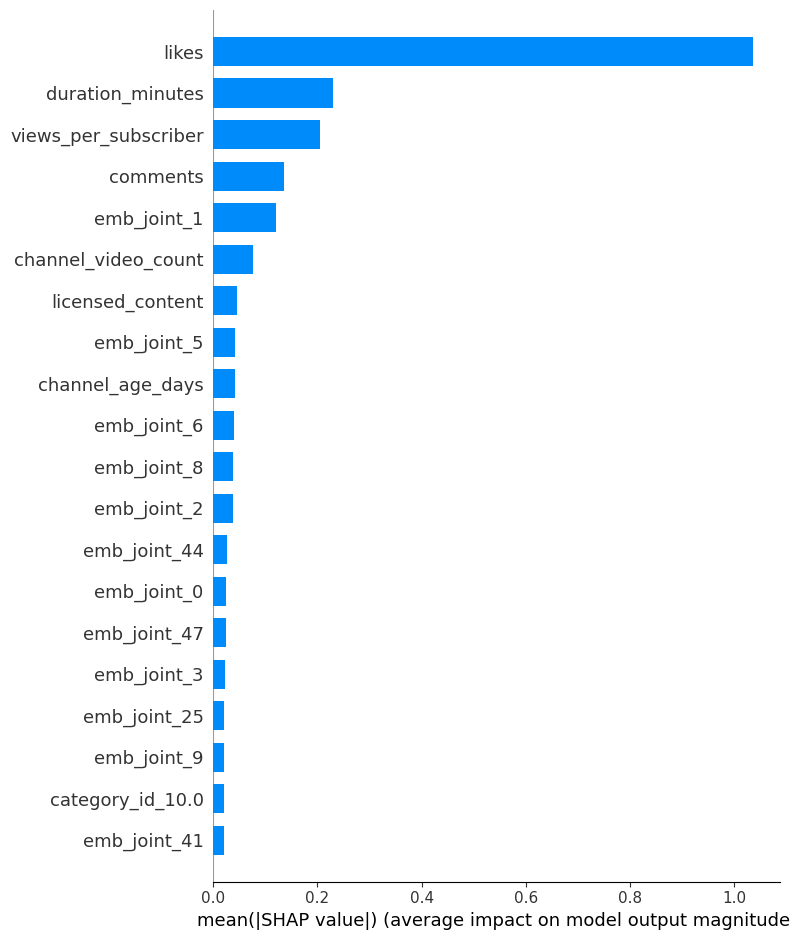

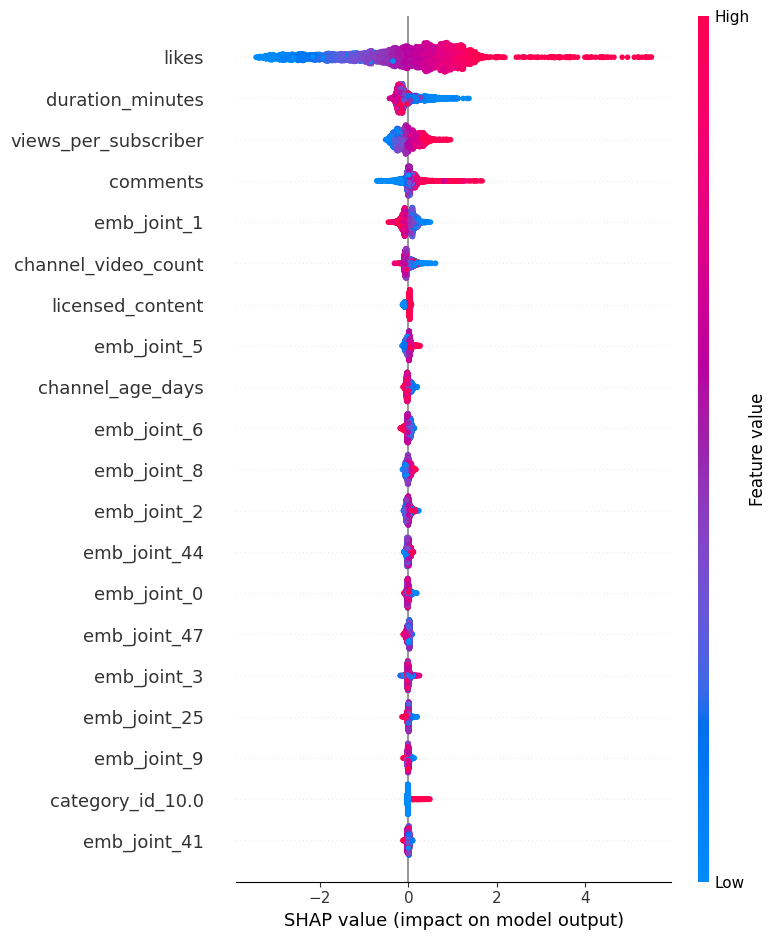

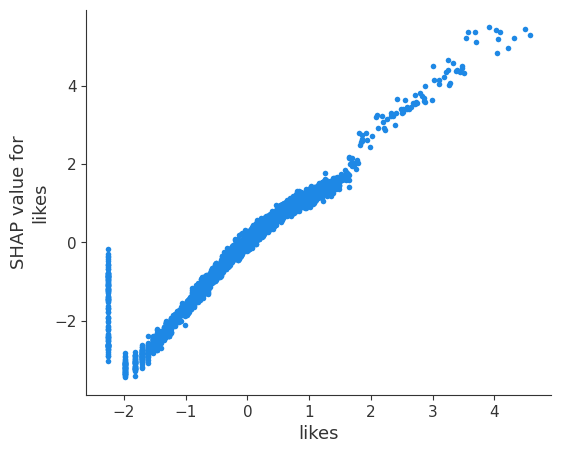

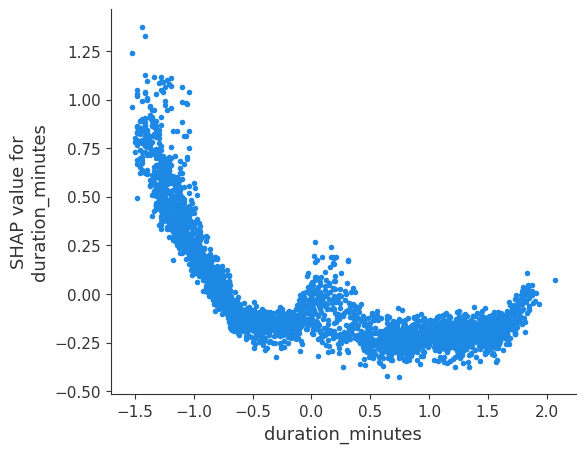

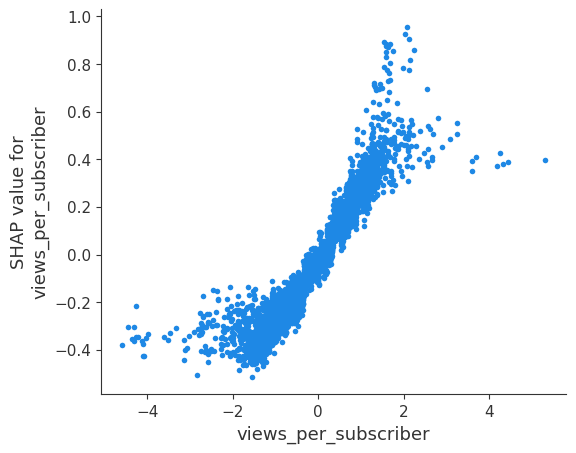

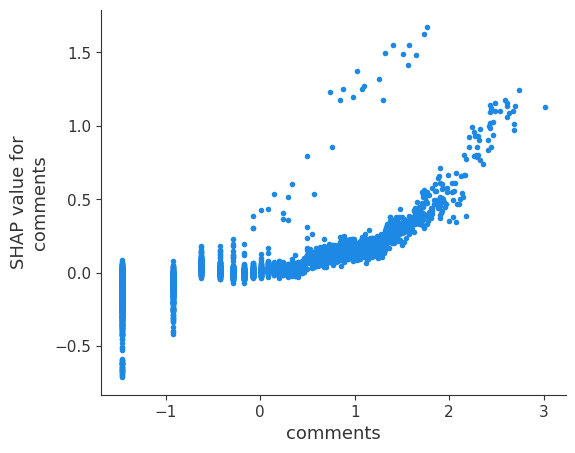

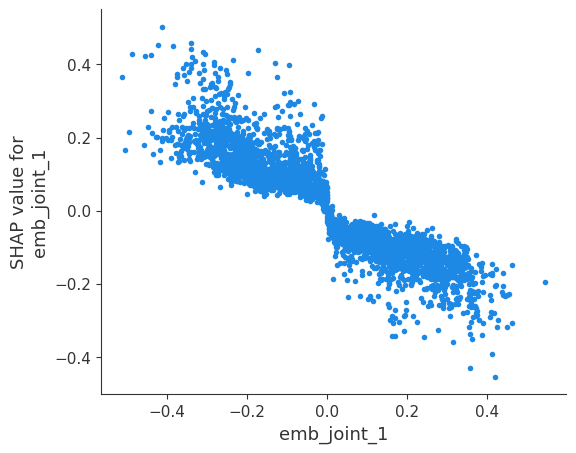

In [12]:
def _resolve_cols(cols, X_sample: pd.DataFrame):
    if callable(cols): 
        cols = cols(X_sample)
    if isinstance(cols, slice): 
        return list(X_sample.columns[cols])
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        if len(cols) > 0 and isinstance(cols[0], (int, np.integer)):
            return list(X_sample.columns[list(cols)])
        if isinstance(cols, (np.ndarray, pd.Index)) and getattr(cols, "dtype", None) == bool:
            return list(X_sample.columns[cols])
        return list(cols)
    return [cols]

def get_ct_feature_names_compat(ct, X_sample: pd.DataFrame):
    """
    Devuelve nombres de salida de un ColumnTransformer 'ct' ya AJUSTADO.
    - Usa get_feature_names_out cuando esté disponible.
    - Para 'passthrough', devuelve los nombres originales.
    - Para trafos opacos, infiere n_cols transformando una muestra.
    """
    out = []
    if not hasattr(ct, "transformers_"):
        raise RuntimeError("ColumnTransformer no está ajustado. Ajusta el pipeline o el CT antes.")

    for name, trans, cols in ct.transformers_:
        if trans == "drop":
            continue
        cols_res = _resolve_cols(cols, X_sample)

        # 1) Transformador con nombres propios
        if hasattr(trans, "get_feature_names_out"):
            try:
                feats = trans.get_feature_names_out(cols_res)
                out.extend(list(feats))
                continue
            except Exception:
                pass

        # 2) Passthrough
        if trans == "passthrough":
            out.extend(cols_res)
            continue

        # 3) Caso opaco: inferir nº de columnas
        X_slice = X_sample[cols_res]
        try:
            Xt = trans.transform(X_slice)
        except Exception:
            n = min(50, len(X_slice))
            Xt = trans.transform(X_slice.iloc[:n])

        Xt = Xt.toarray() if sparse.issparse(Xt) else np.asarray(Xt)
        n_out = Xt.shape[1] if Xt.ndim > 1 else 1
        out.extend([f"{name}_{i}" for i in range(n_out)])

    return np.array(out, dtype=object)

# ========= 1) Toma el pipeline ya entrenado =========
best_pipe = xgb_search.best_estimator_          # <- ESTE sí es un Pipeline fitted
ct = best_pipe.named_steps["preprocessing"]     # ColumnTransformer fitted
model = best_pipe.named_steps["model"]          # XGBRegressor o XGBClassifier fitted

# Si en algún momento activaste salida pandas, aquí usa salida "default" para evitar conflictos con OHE sparse
try:
    ct.set_output(transform="default")
except Exception:
    pass

# ========= 2) Transforma X_test y arma DataFrame denso con nombres =========
X_sample = X_train.iloc[: min(100, len(X_train))].copy()  # para resolver nombres de forma estable
feat_names = get_ct_feature_names_compat(ct, X_sample)

Xt = ct.transform(X_test)  # puede ser sparse
Xt = Xt.toarray() if sparse.issparse(Xt) else np.asarray(Xt)
X_test_df = pd.DataFrame(Xt, columns=feat_names)

# ========= 3) SHAP: TreeExplainer para XGBoost =========
# Para versiones nuevas de shap/xgboost, también sirve shap.Explainer(model)
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_df)  # array (n_samples, n_features)
except Exception:
    # fallback genérico
    explainer = shap.Explainer(model)
    sv = explainer(X_test_df)
    shap_values = sv.values  # (n_samples, n_features)

# ========= 4) Top-20 por |SHAP| medio =========
mean_abs = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(-mean_abs)[:20]
top_df = (pd.DataFrame({"feature": X_test_df.columns[top_idx], "mean_abs_shap": mean_abs[top_idx]})
          .sort_values("mean_abs_shap", ascending=False)
          .reset_index(drop=True))

print("\nTop-20 features por |SHAP| medio:")
display(top_df)

# ========= 5) Plots globales =========
# Ranking global
shap.summary_plot(shap_values, X_test_df, plot_type="bar", max_display=20, show=True)
# Beeswarm: dirección (color) + intensidad (magnitud)
shap.summary_plot(shap_values, X_test_df, max_display=20, show=True)

# ========= 6) Plots de dependencia para las 5 más influyentes =========
for feat in top_df["feature"].head(5):
    try:
        shap.dependence_plot(feat, shap_values, X_test_df, interaction_index=None, show=True)
    except Exception as e:
        print(f"Dependence plot falló para {feat}: {e}")

## 3.1.6. RED NEURONAL

In [13]:

def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X

# -----------------------
# MLP con early stopping
# -----------------------
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),   # capas ocultas: prueba también (64,) o (256,128,64)
    activation="relu",              # función de activación
    solver="adam",                  # optimizador
    alpha=1e-4,                     # regularización L2
    batch_size=256,                 # tamaño del batch
    learning_rate_init=1e-3,        # tasa de aprendizaje inicial
    max_iter=200,                   # épocas máximas
    early_stopping=True,            # para parar si no mejora
    n_iter_no_change=10,            # paciencia para early stopping
    validation_fraction=0.2,        # parte de train usada como validación
    random_state=42,
    verbose=True                    # muestra progreso en entrenamiento
)


pipeline_power = Pipeline(
    steps=[
    ('preprocessing', preprocessor),
    ('model', mlp),
  #  ("to_dense", FunctionTransformer(to_dense))
])

groups = df_1.loc[mask_tr, "channel_id"]  # grupos = canal
gkf = GroupKFold(n_splits=5)

scores = cross_val_score(
    estimator=pipeline_power,
    X=X_train, y=y_train,
    cv=gkf,                 # pasa el objeto, no el generador .split(...)
    groups=groups,          # MUY importante para agrupar por canal
    scoring="r2",
    n_jobs=-1
)
print(f"CV R² (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

# 3) Entrena en TODO el train y evalúa en test hold-out
pipeline_power.fit(X_train, y_train)
y_pred_test = pipeline_power.predict(X_test)


print("Hold-out R²:", r2_score(y_test, y_pred_test))
print("Hold-out MAE:", mean_absolute_error(y_test, y_pred_test))
print("Hold-out RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
eval_regression(pipeline_power,X_train, X_test, y_train, y_test)


Iteration 1, loss = 20.28857373
Validation score: -1.084067
Iteration 2, loss = 1.64356800
Validation score: 0.426922
Iteration 1, loss = 20.18185915
Validation score: -1.133914
Iteration 3, loss = 0.82764419
Validation score: 0.569090
Iteration 1, loss = 20.31659191
Iteration 2, loss = 1.66456813
Iteration 4, loss = 0.65600510
Validation score: -0.943697
Validation score: 0.411647
Validation score: 0.635553
Iteration 3, loss = 0.84917311
Iteration 2, loss = 1.69899086
Validation score: 0.559885
Validation score: 0.462754
Iteration 5, loss = 0.56463603
Validation score: 0.677162
Iteration 1, loss = 20.14736641
Validation score: -1.075557
Iteration 4, loss = 0.67478341
Iteration 3, loss = 0.86465714
Validation score: 0.633083
Validation score: 0.608007
Iteration 6, loss = 0.50580409
Validation score: 0.708191
Iteration 2, loss = 1.61627408
Validation score: 0.435702
Iteration 5, loss = 0.57646789
Validation score: 0.679840
Iteration 4, loss = 0.67629507
Iteration 7, loss = 0.46348111
Va

{'train': {'MAE': 0.4307613318124118,
  'MSE': 0.34498667019098567,
  'RMSE': 0.5873556590269525,
  'R2': 0.9012236441855851,
  'MAPE': 5.604281410600593},
 'test': {'MAE': 0.5431856720015249,
  'MSE': 0.5456528282150156,
  'RMSE': 0.7386831717421317,
  'R2': 0.8395108005377822,
  'MAPE': 6.932332747327677},
 'y_pred_train': array([ 6.9088653 , 13.192309  ,  8.7199154 , ...,  8.33092999,
         8.68992726, 10.25124546]),
 'y_pred_test': array([ 7.96471375,  8.93801011,  8.1813255 , ...,  7.73094437,
        12.04074504,  9.54212192])}